In [1]:
from pathlib import Path
import typing as T
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy
import xarray as xr
import iris
import iris.plot

def plot_region(ax, name: str, centre: T.Tuple[float, float], res: T.Tuple[float, float], size: T.Tuple[int, int], pole: T.Tuple[float, float]=(90,180), rim: int=9, halo: T.Tuple[int, int]=(7,7), **kwargs):
    """
    Plots a LAM region, including its rim and halo
    """
    
    draw_box_centre_size(ax, name, centre, res, size, pole, **kwargs)
    
    rim_size = [size[0]-rim*2, size[1]-rim*2]
    draw_box_centre_size(ax, name + '_rim', centre, res, rim_size, pole, ls='--', **kwargs)
    
    halo_size = [size[0]+halo[0]*2, size[1]+halo[1]*2]
    draw_box_centre_size(ax, name + '_halo', centre, res, halo_size, pole, ls=':', **kwargs)
    
def draw_box_centre_size(ax, name: str, centre: T.Tuple[float, float], res: T.Tuple[float, float], size: T.Tuple[int, int], pole: T.Tuple[float, float]=(90,180), **kwargs):
    """
    Draws a box given its centre and size
    """
    size_lon = res[1] * size[1]
    size_lat = res[0] * size[0]

    draw_box_corners(ax, name, corners=[centre[1]-size_lon/2, centre[1]+size_lon/2, centre[0]-size_lat/2, centre[0]+size_lat/2], pole=pole, **kwargs)
    
def draw_box_corners(ax, name: str, corners: T.Tuple[float, float, float, float], pole: T.Tuple[float, float]=(90,180), **kwargs):
    """
    Draws a box given its corners
    """
    x0,x1,y0,y1 = corners
    
    lons = numpy.linspace(x0,x1)
    lats = numpy.linspace(y0,y1)
        
    crs = ccrs.RotatedGeodetic(pole[1], pole[0])
    ax.plot(lons, [y0]*lons.size, transform=crs, **kwargs, label=name) 
    ax.plot(lons, [y1]*lons.size, transform=crs, **kwargs) 
    ax.plot([x0]*lats.size, lats, transform=crs, **kwargs) 
    ax.plot([x1]*lats.size, lats, transform=crs, **kwargs)

In [2]:
ERA5_land_file = Path('/g/data/zz93/era5-land/reanalysis/2t/2023/2t_era5-land_oper_sfc_20230501-20230531.nc')

In [3]:
ERA5_land = xr.open_dataset(ERA5_land_file)
ERA5_land

<xarray.Dataset> Size: 39GB
Dimensions:    (longitude: 3600, latitude: 1801, time: 744)
Coordinates:
  * longitude  (longitude) float32 14kB -180.0 -179.9 -179.8 ... 179.8 179.9
  * latitude   (latitude) float32 7kB 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time       (time) datetime64[ns] 6kB 2023-05-01 ... 2023-05-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float64 39GB ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-01 22:23:11 UTC+1000 by era5_replication_tools-1.12...
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 land 2m_temperature 20230501-20230531

In [9]:
print(ERA5_land.sel(latitude=slice(-39,-41),longitude=slice(144,145))["latitude"].values)
print(ERA5_land.sel(latitude=slice(-39,-41),longitude=slice(144,145))["longitude"].values)

[-39.  -39.1 -39.2 -39.3 -39.4 -39.5 -39.6 -39.7 -39.8 -39.9 -40.  -40.1
 -40.2 -40.3 -40.4 -40.5 -40.6 -40.7 -40.8 -40.9 -41. ]
[144.  144.1 144.2 144.3 144.4 144.5 144.6 144.7 144.8 144.9 145. ]


In [45]:
CENTRE=[-40.8,144.8]
ERA_RES=[0.1,0.1]
ERA_SIZE=[340,420]

CAPE_K_11p1_RES=ERA_RES
CAPE_K_11p1_SIZE=[320,400]

CAPE_K_5_RES=[0.045,0.045]
CAPE_K_5_SIZE=[500,600]

CAPE_K_1_RES=[0.009,0.009]
CAPE_K_1_SIZE=[1100,1300]


In [18]:
ERA5_land.t2m.sel(longitude=slice(100,200),latitude=slice(-5,-70))

<xarray.DataArray 't2m' (time: 744, latitude: 651, longitude: 800)> Size: 3GB
[387475200 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 3kB 100.0 100.1 100.2 ... 179.7 179.8 179.9
  * latitude   (latitude) float32 3kB -5.0 -5.1 -5.2 -5.3 ... -69.8 -69.9 -70.0
  * time       (time) datetime64[ns] 6kB 2023-05-01 ... 2023-05-31T23:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

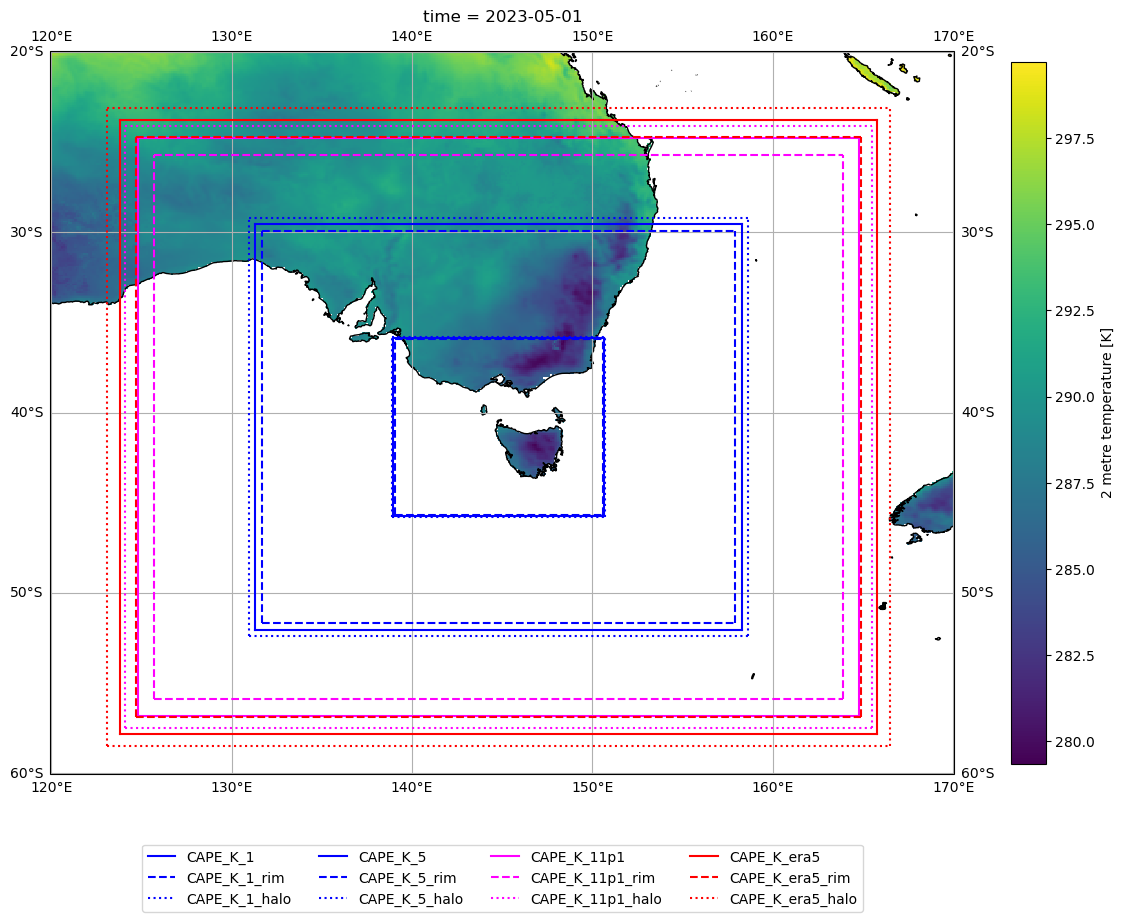

In [46]:
plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ERA5_land.t2m.sel(longitude=slice(120,170),latitude=slice(-20,-60),time="2023-05-01 00:00").plot(
    ax=ax,
    cbar_kwargs={"orientation": "vertical", "shrink": 0.6, "aspect": 20})
ax.gridlines(draw_labels=True)

plot_region(ax, 'CAPE_K_1', centre=CENTRE, res=CAPE_K_1_RES, size=CAPE_K_1_SIZE, color='b')
plot_region(ax, 'CAPE_K_5', centre=CENTRE, res=CAPE_K_5_RES, size=CAPE_K_5_SIZE, color='b')
plot_region(ax, 'CAPE_K_11p1', centre=CENTRE, res=CAPE_K_11p1_RES, size=CAPE_K_11p1_SIZE, color='magenta')
plot_region(ax, 'CAPE_K_era5', centre=CENTRE, res=ERA_RES, size=ERA_SIZE, color='r')
ax.coastlines('10m')
ax.legend(loc='lower center',bbox_to_anchor=(0.5,-0.2),ncols=4);
plt.tight_layout()